# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Load the data

First, we load the data and get a sample of the original dataset because we want to reduce the computation time. The original dataset contains 891.211 rows and 366 columns. After loading the data, we get a datatype warning saying that the columns 18 and 19 contain mixed types. We will hanlde this error in the preprocessing part.

In [3]:
# Load in the data
azdias_all = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias_all.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
# We sample part of the data, because we want to reduce the computation time
azdias = azdias_all.sample(frac=0.25, replace=False, random_state=42)
azdias_copy = azdias.copy(deep=True)

In [6]:
azdias.shape

(222805, 366)

## Part 1: Preprocessing

### 1.1 Assess missing data in each column

We calculate the NaN values in each column and plot the percentage of missing values per column in a bar plot. The plot shows that most of the features have less than 40% of missing values, and therefore decide to drop all the columns with missing values over this threshold.

In [7]:
# How many nans are present in each column of the dataset
stats_col_df = pd.DataFrame(azdias.isnull().sum(axis=0)/azdias.shape[0],columns=['% of missing values'])

display(stats_col_df.describe())

,% of missing values
count,366.000000
mean,0.102908
std,0.121675
min,0.000000
25%,0.000000
50%,0.119364
75%,0.120496
max,0.998748


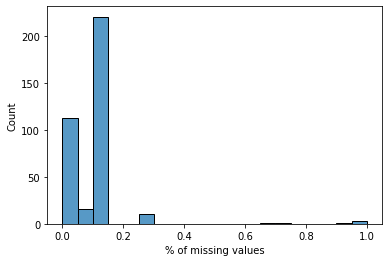

In [8]:
# Plot the amount of missing data in each column.
miss_data_col = stats_col_df['% of missing values']
plt.figure(figsize=(6,4))

sns.histplot(miss_data_col, bins= 20)
#plt.hist(miss_data_col, bins=100)
plt.xlabel('% of missing values')
plt.show()

In [9]:
# Keep the columns that have less than 40% of missing values
keep_cols = list(stats_col_df[stats_col_df['% of missing values'] <= 0.4].index)
azdias_reduced = azdias[keep_cols]

After dropping the outlier columns, we confirm the names of the columns dropped by using the set difference of the column names of the original and reduced dataset. There are 6 columns dropped with the names: 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',  'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP'.

In [10]:
# Print the dropped columns
set(azdias.columns) - set(keep_cols)

{'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KK_KUNDENTYP'}

### 1.2 Assess missing data in each row

After having removed the outlier columns, we assess the missing values in each row. We calculate the Nan values in each row and plot the percentage of missing values per column.

In [11]:
# How many nans are present in each row of the dataset
stats_row_df = pd.DataFrame(azdias.isnull().sum(axis=1)/azdias.shape[1],columns=['% of missing values'])

display(stats_row_df.describe())

,% of missing values
count,222805.000000
mean,0.102908
std,0.206074
min,0.000000
25%,0.013661
50%,0.016393
75%,0.043716
max,0.707650


From the plot below, we observe that most of the rows have less than 40% of missing values, and we drop all the columns with missing values over this threshold.

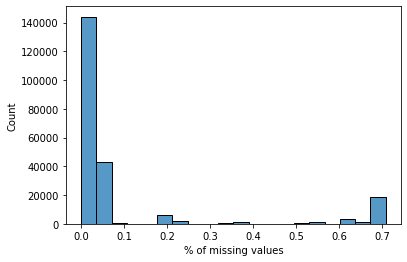

In [12]:
# Plot the amount of missing data in each row.
miss_data_row = stats_row_df['% of missing values']
sns.histplot(miss_data_row, bins=20)
plt.xlabel('% of missing values')
plt.show()

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_mm = azdias_reduced[stats_row_df['% of missing values']>0.40]
azdias_fm = azdias_reduced[stats_row_df['% of missing values']<=0.40]
print(azdias_mm.shape)
print(azdias_fm.shape)

(24902, 360)
(197903, 360)


In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#fig = plt.figure(figsize=(26,10))
#col_list = ['ALTERSKATEGORIE_GROB','FINANZTYP','FINANZ_VORSORGER','LP_STATUS_FEIN','HH_EINKOMMEN_SCORE','ANREDE_KZ']
##sns.color_palette("pastel", desat=0.9)
#sns.set_palette('Set2')
#for i,col in enumerate(col_list):
#    plt.subplot(2, len(col_list), i+1)
#    sns.countplot(azdias_mm[col])
#    plt.subplot(2, len(col_list), i+len(col_list)+1)
#    sns.countplot(azdias_fm[col])

### 1.3 Fix the data type error

We get the name of the columns with the datatype error and check the unique values in each column. We observe that the affected columns are 'CAMEO_DEUG_2015' and 'CAMEO_INTL_2015'. Column 'CAMEO_DEUG_2015' apart from the numerical and NaN values contains the character 'X', whereas column 'CAMEO_INTL_2015' contains the character 'XX'.

In [15]:
# Print the name of the columns with the datatype error
print(azdias.iloc[:,18:20].columns)

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [16]:
# Print the unique values of the columns with the datatype error
display(azdias_copy.iloc[:,18].unique(), azdias_copy.iloc[:,19].unique())

array(['9', 4.0, '4', 3.0, nan, 9.0, '2', '8', 2.0, '1', '7', '5', 8.0,
       7.0, '3', '6', 6.0, 5.0, 1.0, 'X'], dtype=object)

array(['51', 24.0, '24', 23.0, nan, 51.0, '13', '55', 13.0, '15', '14',
       '12', '41', '34', '52', 54.0, '25', '43', 14.0, 22.0, '54', '22',
       12.0, '35', 43.0, '44', 44.0, '23', 55.0, 25.0, 41.0, '31', 45.0,
       32.0, '45', 15.0, 34.0, 33.0, 35.0, 52.0, '32', 31.0, 'XX', '33'],
      dtype=object)

In [17]:
# Replace the characters with Nan and convert the values into numerical values
convert_dict = {'CAMEO_DEUG_2015': float, 'CAMEO_INTL_2015': float}

azdias.iloc[:,17:20] = azdias.iloc[:,17:20].replace(['X','XX'], np.NaN)
azdias = azdias.astype(convert_dict)

### 1.4 Handle categorical values

Next, we print the columns which still contain non-numerical values. These are the columns 'CAMEO_DEU_2015',	'D19_LETZTER_KAUF_BRANCHE',	'EINGEFUEGT_AM', and 'OST_WEST_KZ'.

In [18]:
# Print the columns that contain non numerical values
azdias.select_dtypes(exclude=['number']).head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
848815,9B,D19_UNBEKANNT,1992-02-12 00:00:00,W
299816,4C,D19_BANKEN_DIREKT,1992-02-10 00:00:00,W
570748,4C,NaN,1994-08-30 00:00:00,W
354371,3A,D19_VERSICHERUNGEN,2005-10-11 00:00:00,W
329018,NaN,NaN,NaN,NaN


The column "CAMEO_DEU_2015" contains values with 2 digits, one numerical digit (1–9) and one alphabetical digit (A-E). Each digit represents a different category, therefore we split the column into 2 columns and re-encode the alphabetical digits to numerical values. Some columns also contain the value 'XX' which similar to above, we replace with NaN.

In [19]:
# Replace "CAMEO_DEU_2015" categorical values with new variables

def first_dg_dict(x):
    '''
    Returns the first letter of a string
    
    INPUT: 
        x - the string which we want to split
            
    OUTPUT:
        The first letter of the string
    '''
    if pd.isnull(x) or 'XX':
        return np.nan
    else:
        return int(str(x)[0])
    
def second_dg_dict(x):
    '''
    Returns the second letter of a string
    
    INPUT: 
        x - the string which we want to split
            
    OUTPUT:
        The second letter of the string
    '''
    if pd.isnull(x) or 'XX':
        return np.nan
    else:
        return str(x)[1]
    

azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].apply(first_dg_dict)
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].apply(second_dg_dict)

The column "OST_WEST_KZ" indicates whether the person lives in East(O) or West(W) Germany. To convert the column into numerical we replace O and W with 0 and 1 respectively.

In [20]:
replace_dict = {'O': 0,'W': 1}
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace(replace_dict)

Finally, we drop the columns "D19_LETZTER_KAUF_BRANCHE" and "EINGEFUEGT_AM", because from the title description we conclude they are not relevant to the problem we are trying to solve.

In [21]:
azdias.drop(columns=['D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM', 'LNR'],inplace=True)

### 1.5 Create a data cleaning function

We create a function to perform the steps above, because we want to apply the preprocessing steps to the customers dataset in the next step.

In [28]:
def first_dg_dict(x):
    '''
    Returns the first letter of a string
    
    INPUT: 
        x - the string which we want to split
            
    OUTPUT:
        The first letter of the string
    '''
    
    if pd.isnull(x) or 'XX':
        return np.nan
    else:
        return int(str(x)[0])
    
def second_dg_dict(x):
    '''
    Returns the second letter of a string
    
    INPUT: 
        x - the string which we want to split
            
    OUTPUT:
        The second letter of the string
    '''
    
    if pd.isnull(x) or 'XX':
        return np.nan
    else:
        return str(x)[1]
    
def convert_letters(x):
    '''
    Maps the alphabetical digits to numerical values.
    
    INPUT: 
        x - the string which we want to convert
            
    OUTPUT:
        The numerical value as per the mapping dictionary
    '''
    
    cameo_dict =   {'A': 1,'B': 2,'C': 3,'D': 4,'E': 5}
    
    if x in  cameo_dict.keys():
        return cameo_dict[x]
    else:
        return np.nan

    
def data_stats_column(df):
    '''
    Computes the percentage of missing values in each column
    
    INPUT: 
        df - the dataframe for which we want to compute the missing values
            
    OUTPUT:
        ds - a new dataframe containing the percentage of missing values in each column of df
    '''
    
    ds = pd.DataFrame(df.isnull().sum(axis=0)/df.shape[0],columns=['% of missing values'])
    return ds

def data_stats_row(df):
    '''
    Computes the percentage of missing values in each row
    
    INPUT: 
        df - the dataframe for which we want to compute the missing values
            
    OUTPUT:
        ds - a new dataframe containing the percentage of missing values in each row of df
    '''
    
    ds = pd.DataFrame(df.isnull().sum(axis=1)/df.shape[1],columns=['% of missing values'])
    return ds

def plot_stats_column(df):    
    '''
    Runs the data_stats_column() function and plots a histogram plot with the percentage of missing value for each column
    
    INPUT: 
        df - the dataframe for which we want to plot the missing values
        
    '''
    
    miss_data_col = data_stats_column(df)['% of missing values']
    plt.hist(miss_data_col, bins=20)
    plt.xlabel('% of missing values')
    plt.show()
    
def plot_stats_row(df):    
    '''
    Runs the data_stats_row() function and plots a histogram plot with the percentage of missing value for each column
    
    INPUT: 
        df - the dataframe for which we want to plot the missing values
        
    '''
    
    miss_data_row = data_stats_row(df)['% of missing values']
    plt.hist(miss_data_row, bins=20)
    plt.xlabel('% of missing values')
    plt.show()
    
def clean_data(df):
    '''
    Returns a dataframe with numerical values and cleaned from the outlier columns and rows.
    
    INPUT: 
        df - the original dataframe with mixed type columns
            
    OUTPUT:
        reduced_df - the new dataframe with numerical values and with oulier columns and rows removed.
    '''
    
    convert_dict = {'CAMEO_DEUG_2015': float,'CAMEO_INTL_2015': float}
    germ_dict = {'O': 0,'W': 1}
    
    # fix the data type error
    df.iloc[:,17:20] = df.iloc[:,18:20].replace(['X','XX'], np.NaN)
    df = df.astype(convert_dict)
    
    # drop not relevant columns
    df.drop(columns=['D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM', 'LNR'],inplace=True)
    
    # Replace "CAMEO_DEU_2015" categorical values with new variables.
    df['CAMEO_DEU_2015_first_dg'] = df['CAMEO_DEU_2015'].apply(first_dg_dict)
    df['CAMEO_DEU_2015_second_dg'] = df['CAMEO_DEU_2015'].apply(second_dg_dict)
    df['CAMEO_DEU_2015_second_dg'] = df['CAMEO_DEU_2015_second_dg'].apply(convert_letters)
    
    df.drop(columns=['CAMEO_DEU_2015'],inplace=True)

    # Re-encode "Ost", "West" values with 0s and 1s.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(germ_dict)
    
    # Asses missing data on each column
    stats_col_df = data_stats_column(df)
    keep_cols_ls = list(stats_col_df[stats_col_df['% of missing values'] <= 0.4].index)
    reduced_df = df[keep_cols_ls]
    
    # Asses missing data on each row
    stats_row_df = data_stats_row(reduced_df)
    reduced_df = reduced_df[stats_row_df['% of missing values']<=0.40]
    
    return reduced_df


azdias = azdias_copy
azdias_reduced = clean_data(azdias)
#plot_stats_column(azdias)  
#plot_stats_row(azdias)  


## Part 2: Customer Segmentation Report

The main bulk of the analysis comes in this part of the project. Here, we use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, we will be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 2.1 Impute missing values

In [29]:
azdias_reduced.select_dtypes(exclude=['number']).head()
azdias_reduced['CAMEO_DEUG_2015'].unique()

array([ 9.,  4.,  3.,  2.,  8.,  1.,  7.,  5.,  6., nan])

In [30]:
# Impute missing values by replacing NaNs in a column with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_reduced),columns = azdias_reduced.columns)
azdias_imputed.index=azdias_reduced.index

### 2.2 Scale and center the features

In [31]:
# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed),columns = azdias_imputed.columns)
azdias_scaled.index = azdias_imputed.index

In [32]:
azdias_scaled.shape

(197909, 356)

### 2.3 Reduce dimensionality

In this step, we apply singular value decomposition using the PCA transformer from sklearn, because we want to reduce the amount of features for the clustering algorithm. To explore how the explained variance is varying with the number of principal components we plot the cumulative explained variance against the number of components. We observe that XXX components account for 90% of the explained variance, hence we decide to drop the remaining components.

In [33]:
# Define the pca function to reuse in the customer data 

def apply_pca(n_comps, df):
    '''
    Returns a dataframe 
    
    INPUT: 
        n_comps - the number of components for the pca analysis
        df - a dataframe of shape (n_samples, n_features)
            
    OUTPUT:
        pca_arr - an ndarray of shape (n_samples, n_components)
        pca_df - a dataframe of shape (n_samples, n_components)
    '''
    
    pca_model = PCA(n_comps)
    pca_arr = pca_model.fit_transform(df)
    pca_df = pd.DataFrame(data = pca_arr)
    return pca_model, pca_df

In [34]:
pca_model, pca_df =  apply_pca(azdias_scaled.shape[1],azdias_scaled)

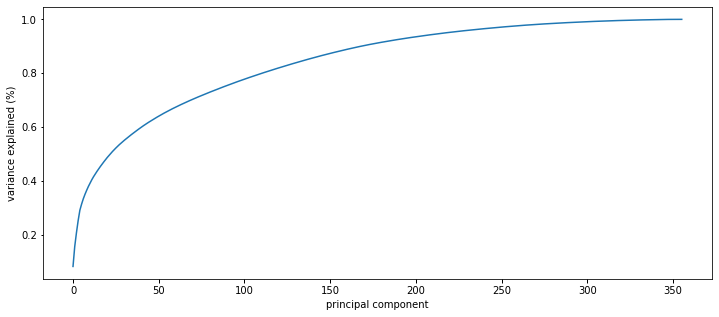

In [36]:
# Investigate the variance accounted for by each principal component.

def plot_pca(pca_model):
    '''
    Creates a plot with variance explained by the principal components 
    
    INPUT: pca_model - the pca model with the pricipal components
            
    OUTPUT:
            None
    '''
    
    num_components = len(pca_model.explained_variance_ratio_)
    var_explained = pca_model.explained_variance_ratio_
    plt.figure(figsize=(12, 5))
    
    ax = plt.subplot(111)
    cumsum = np.cumsum(var_explained)
    ax.plot(np.arange(num_components), cumsum)
    
    ax.xaxis.set_tick_params(width=1)
    ax.yaxis.set_tick_params(width=1, length=2)
 
    ax.set_xlabel("principal component")
    ax.set_ylabel("variance explained (%)")
    #plt.title('explained variance vs. number of principal components')
    
plot_pca(pca_model)

In [37]:
num_components = len(pca_model.explained_variance_ratio_)
vals = pca_model.explained_variance_ratio_
cumvals = np.cumsum(vals)
ind = np.arange(num_components)
pca_df = pd.DataFrame(cumvals,ind)

In [38]:
# Get the number of components for variance explained > 0.9
pca_df.loc[pca_df[0]>0.9].head(1)

,0
168,0.900332


In [39]:
# Re-apply PCA to the data while selecting for number of components to retain.
n = 168
pca_red_model, pca_red_df = apply_pca(n, azdias_scaled)

In [52]:
#Map components relations with features:
pca_df = pd.DataFrame(pca_model.components_,columns=azdias_scaled.columns)

# Return features with highest weights for each component
def map_to_features(pca_df, pca_idx):        
    '''
    Returns the features with highest weights for each component
    
    INPUT: 
        pca_df - a dataframe containing an array of [n_components, n_features]
        pca_idx - the index of the nth component for which we want to recover the features
            
    OUTPUT:
        The top 5 features with the highest association with the nth component
    '''

    sorted_df = pca_df.iloc[pca_idx].abs().sort_values(ascending=False)
    
    return sorted_df.head(5)

In [53]:
# Return the top features for the 1st principal component
top_feats = map_to_features(pca_df, pca_idx=0)
display(top_feats)

KBA13_ANTG1       0.120841
PLZ8_ANTG1        0.120785
KBA13_ANTG3       0.120125
LP_STATUS_FEIN    0.119712
PLZ8_ANTG3        0.119652
Name: 0, dtype: float64

### 2.4 Clustering

Finally, we perform clustering using K-Means. K-means is a general-purpose clustering algorithm that scales well to large number of samples. It takes as parameter the number of clusters (k) and clusters the data by trying to minize the distance of the points from the center of the cluster (centroid). To decide on the number of clusters we run k-means clustering on the dataset for a range of values for k (from 1–20). For each value of k we compute the distortion score, which is the sum of square distances from each point to its assigned center. By plotting the score for each model, it is possible to visually determine the best value for k.

In [61]:
k = 20
scores = []
centers = list(range(1, k+1))
    
for center in (centers):
    kmeans = KMeans(n_clusters=center, random_state=42)
    model = kmeans.fit(pca_red_df)
    score = np.abs(model.score(pca_red_df))
    scores.append(score)

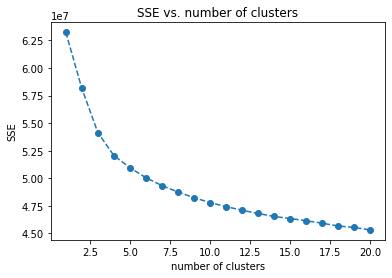

In [62]:
# Investigate the change in within-cluster distance across number of clusters.
def elbow_plot(centers, scores):
    
    plt.plot(centers, scores, linestyle='--', marker='o');
    plt.xlabel('number of clusters');
    plt.ylabel('SSE');
    plt.title('SSE vs. number of clusters');
    
elbow_plot(centers, scores)

In [ ]:
n_clusters = 5

In [125]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=n_clusters, n_init =4, random_state=132)
azdias_labels = kmeans.fit_predict(pca_red_df)

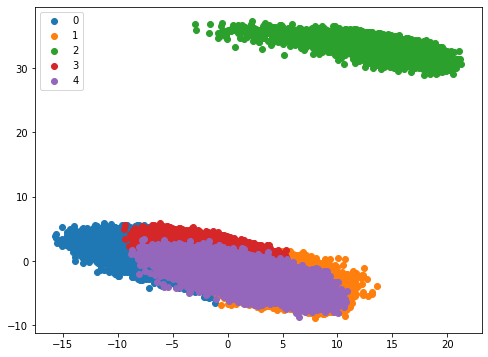

In [129]:
# Visualize the clusters using the 2 principal components
labels = np.unique(azdias_labels)
df = pd.DataFrame(azdias_labels)

# Select the 2 principal components to plot
pca_2_arr = pca_red_df.iloc[:,0:2].values

plt.figure(figsize=(8, 6))

for i in labels:
    plt.scatter(pca_2_arr[df[0] == i , 0] , pca_2_arr[df[0] == i , 1] , label = i)

plt.legend()
plt.show()

### 2.5 Apply steps to the customer dataset

Now we are ready to run the steps above on the customers dataset, which we load from the file 'Udacity_CUSTOMERS_052018.csv'. The 'customers' dataframe contains 3 extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'). We will drop these columns for this part of the analysis.

In [ ]:
# Load the customers dataset
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Get the set difference between the columns of the customers and general population dataset
azdias_all.columns.symmetric_difference(customers.columns)

In [ ]:
# Drop the 3 additional columns of the customers dataset
customers = customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])

In [133]:
# Apply the data cleaning steps from the general population dataset to the customers dataset
customers_reduced = clean_data(customers)

In [ ]:
#Perform data preprocessing for the clustering algorithm
customers_imputed = pd.DataFrame(imputer.transform(customers_reduced),
                                 columns = customers_reduced.columns,
                                 index=customers_reduced.index)

In [ ]:
#Scale the data using standard scaler
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed),
                                 columns = customers_reduced.columns,
                                 index=customers_reduced.index)

In [ ]:
customers_scaled.head(5)

In [137]:
#Apply PCA for dimensionality reduction
pca_cust_model, pca_cust_df = apply_pca(168, customers_scaled)

In [138]:
customer_clusters = kmeans.predict(pca_cust_df)

### 2.6 Compare Customer Data to Demographics Data

In this step, we want to identify if there are any differences between the relative population size assigned to each cluster in the general and customer datasets. Thus, we plot the relative size of samples on each cluster and compare the results. From the plot results we observe that there are some clusters where the customers population is over-represented compared to the general population. Hence, the individuals from the general population assigned to these clusters, are more likely to become new clients.

In [144]:
cluster_df = pd.DataFrame([])

cluster_df['GenPopulation'] = pd.Series(azdias_labels).value_counts().sort_index()
cluster_df['Customers'] = pd.Series(customer_clusters).value_counts().sort_index()
cluster_df.reset_index(inplace=True)
cluster_df.rename(columns={'index':'Cluster'}, inplace=True)
cluster_df

,Cluster,GenPopulation,Customers
0,0,48973,38341.0
1,1,54800,40955.0
2,2,3674,NaN
3,3,65561,58155.0
4,4,24901,3438.0


In [145]:
cluster_df['GenPopulation(%)'] = (cluster_df['GenPopulation'] / (cluster_df['GenPopulation'].sum()) * 100).round(2)
cluster_df['Customers(%)'] = (cluster_df['Customers'] / (cluster_df['Customers'].sum()) * 100).round(2)
cluster_df.drop(columns=['GenPopulation','Customers'], inplace=True)

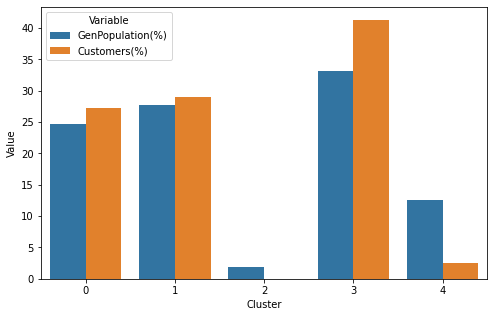

In [146]:
fig, ax1 = plt.subplots(figsize=(8, 5))
plot_df = cluster_df.melt(id_vars='Cluster').rename(columns=str.title)
plot_df.fillna(0)
a = sns.barplot(x='Cluster', y='Value', hue='Variable', data=plot_df)

Discussion:
We observe that there are some clusters where the customers population is overrepresented compared to the general population. It means, that for the population from these clusters, with higher confidence that they can become future customers.

## Part 3: Supervised Learning Model

Now that we have found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### 3.1 Load the training data

In [147]:
# Load the "MAILOUT" training dataset
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0    42430
1      532
Name: RESPONSE, dtype: int64

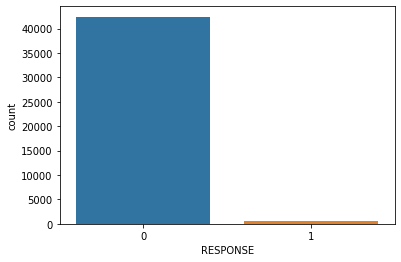

In [148]:
ax = sns.countplot(x='RESPONSE', data=mailout_train)
mailout_train['RESPONSE'].value_counts()

In [149]:
azdias.columns.symmetric_difference(mailout_train.columns)

Index(['RESPONSE'], dtype='object')

### 3.2 Balance and clean the data

We observe that the 2 classes in the "RESPONSE" column of the "MAILOUT" data are highly imbalance. Specifically, the number of data with response value 1 is much less (532) compared to the data with response 0 (42.430). To address the class imbalance, we use sklearn's resample function to balance the dataset for the further analysis.

In [150]:
resp0 = mailout_train[mailout_train['RESPONSE']==0] 
resp1 = mailout_train[mailout_train['RESPONSE']==1]
resp0.shape, resp1.shape

((42430, 367), (532, 367))

In [159]:
# Balance the dataset
resp1_bal = resample(resp1, replace=True, n_samples=42430, random_state=42)

In [160]:
mailout_train_bal = pd.concat([resp0, resp1_bal])

In [ ]:
# Shuffle the data after adding the new samples
mailout_train_bal = mailout_train_bal.sample(frac=1)

Next, we clean the data using the clean_data() function defined in section 1.5.

In [161]:
# Clean the data
mailout_train_bal = clean_data(mailout_train_bal)

To prepare the data for the training of the classifier we extract the 'RESPONSE' column  and drop it from the training data.

In [ ]:
# Get the label column
response_df = mailout_train_bal['RESPONSE']

In [ ]:
# Drop the label column from the training dataframe
mailout_train_bal.drop(columns=['RESPONSE'],inplace=True)

### 3.3 Engineer the customer segmentation feature

To include the findings of our analysis from the customer segmentation part, we run the k-means clustering on the dataset and store the result in an additional column 'Label'.  The column contains the cluster to which which each individual from the mailout dataset is assigned.

In [ ]:
# Create the pipeline with the preprocessing and clustering steps from part 2
pipeline = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('scal', StandardScaler()),
    ('pca', PCA(168)),
    ('clus', KMeans(n_clusters=5))
    ])

In [166]:
# Fit the model
pipe_model = pipeline.fit(mailout_train_bal)

In [167]:
# Predict the labels for the mailout train dataset
mailout_train_clusters = pipe_model.predict(mailout_train_bal)

In [168]:
# Add a new column in the dataset to store the clustering result
mailout_train_bal['Label'] = pd.Series(mailout_train_clusters)

### 3.4 Select the classification model

In [170]:
int_range = [2, 4]
float_range = [0.1, 1.0]
n_estimators = [50, 100, 200]
learning_rate = [.1,.3]

params_lr = [{'pca__n_components': n_estimators,
              'LR__C': float_range,
              'LR__penalty': ['l1', 'l2'],
              'LR__solver': ['liblinear']}]

params_knn = [{'pca__n_components': n_estimators,
               'KNN__n_neighbors': int_range,
               'KNN__weights': ['uniform', 'distance'],
               'KNN__metric': ['euclidean', 'manhattan']}]

params_adb = [{'pca__n_components': n_estimators,
               'ADB__n_estimators': n_estimators, 
               'ADB__learning_rate': learning_rate}]

In [171]:
pipe_lr = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('scal', StandardScaler()),
    ('pca', PCA()),
    ('LR', LogisticRegression(random_state=42)),
    ]) 

pipe_knn = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('scal', StandardScaler()),
    ('pca', PCA()),
    ('KNN', KNeighborsClassifier()),
    ]) 

pipe_adb = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('scal', StandardScaler()),
    ('pca', PCA()),
    ('ADB', AdaBoostClassifier(random_state=42)),
    ]) 

In [172]:
scoring = 'roc_auc'
cv = 2
verbose = 3

grid_search_lr = GridSearchCV(estimator=pipe_lr,
        param_grid=params_lr,
        scoring=scoring,
        cv=cv, verbose=verbose)

grid_search_knn = GridSearchCV(estimator=pipe_knn,
        param_grid=params_knn,
        scoring=scoring,
        cv=cv, verbose=verbose)

grid_search_adb = GridSearchCV(estimator=pipe_adb,
        param_grid=params_adb,
        scoring=scoring,
        cv=cv, verbose=verbose)

In [173]:
mailout_train_bal_sample = mailout_train_bal.sample(frac=0.25)
response_df_sample = response_df[response_df.index.isin(mailout_train_bal_sample.index)]

In [174]:
n = 20000
grids = [grid_search_lr, grid_search_knn, grid_search_adb]
for pipe in grids:
    pipe.fit(mailout_train_bal[:n],response_df[:n])

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] LR__C=0.1, LR__penalty=l1, LR__solver=liblinear, pca__n_components=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  LR__C=0.1, LR__penalty=l1, LR__solver=liblinear, pca__n_components=50, score=0.6905266477482183, total=   0.9s
[CV] LR__C=0.1, LR__penalty=l1, LR__solver=liblinear, pca__n_components=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  LR__C=0.1, LR__penalty=l1, LR__solver=liblinear, pca__n_components=50, score=0.6985302282373842, total=   0.9s
[CV] LR__C=0.1, LR__penalty=l1, LR__solver=liblinear, pca__n_components=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV]  LR__C=0.1, LR__penalty=l1, LR__solver=liblinear, pca__n_components=100, score=0.7637865552935815, total=   1.4s
[CV] LR__C=0.1, LR__penalty=l1, LR__solver=liblinear, pca__n_components=100 
[CV]  LR__C=0.1, LR__penalty=l1, LR__solver=liblinear, pca__n_components=100, score=0.7704096522487098, total=   1.4s
[CV] LR__C=0.1, LR__penalty=l1, LR__solver=liblinear, pca__n_components=200 
[CV]  LR__C=0.1, LR__penalty=l1, LR__solver=liblinear, pca__n_components=200, score=0.795984477720263, total=   3.0s
[CV] LR__C=0.1, LR__penalty=l1, LR__solver=liblinear, pca__n_components=200 
[CV]  LR__C=0.1, LR__penalty=l1, LR__solver=liblinear, pca__n_components=200, score=0.7982421234998361, total=   3.0s
[CV] LR__C=0.1, LR__penalty=l2, LR__solver=liblinear, pca__n_components=50 
[CV]  LR__C=0.1, LR__penalty=l2, LR__solver=liblinear, pca__n_components=50, score=0.7008037540576103, total=   0.9s
[CV] LR__C=0.1, LR__penalty=l2, LR__solver=liblinear, pca__n_components=50 
[CV]  LR__C=0.1, LR__penalty=

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   48.0s finished


Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=uniform, pca__n_components=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=uniform, pca__n_components=50, score=0.9801317891373802, total=   6.3s
[CV] KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=uniform, pca__n_components=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV]  KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=uniform, pca__n_components=50, score=0.9776357827476039, total=   6.0s
[CV] KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=uniform, pca__n_components=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.6s remaining:    0.0s


[CV]  KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=uniform, pca__n_components=100, score=0.9830271565495208, total=  15.8s
[CV] KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=uniform, pca__n_components=100 
[CV]  KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=uniform, pca__n_components=100, score=0.9803314696485623, total=  16.9s
[CV] KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=uniform, pca__n_components=200 
[CV]  KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=uniform, pca__n_components=200, score=0.9730431309904153, total=  31.6s
[CV] KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=uniform, pca__n_components=200 
[CV]  KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=uniform, pca__n_components=200, score=0.9705471246006391, total=  30.7s
[CV] KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=distance, pca__n_components=50 
[CV]  KNN__metric=euclidean, KNN__n_neighbors=2, KNN__weights=distance, pca__n_components=50

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 28.4min finished


Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] ADB__learning_rate=0.1, ADB__n_estimators=50, pca__n_components=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ADB__learning_rate=0.1, ADB__n_estimators=50, pca__n_components=50, score=0.7092393956528529, total=   4.0s
[CV] ADB__learning_rate=0.1, ADB__n_estimators=50, pca__n_components=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV]  ADB__learning_rate=0.1, ADB__n_estimators=50, pca__n_components=50, score=0.7068430095181044, total=   3.9s
[CV] ADB__learning_rate=0.1, ADB__n_estimators=50, pca__n_components=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.2s remaining:    0.0s


[CV]  ADB__learning_rate=0.1, ADB__n_estimators=50, pca__n_components=100, score=0.7529297475001535, total=   7.3s
[CV] ADB__learning_rate=0.1, ADB__n_estimators=50, pca__n_components=100 
[CV]  ADB__learning_rate=0.1, ADB__n_estimators=50, pca__n_components=100, score=0.7177460374298559, total=   7.4s
[CV] ADB__learning_rate=0.1, ADB__n_estimators=50, pca__n_components=200 
[CV]  ADB__learning_rate=0.1, ADB__n_estimators=50, pca__n_components=200, score=0.8376314843366, total=  14.7s
[CV] ADB__learning_rate=0.1, ADB__n_estimators=50, pca__n_components=200 
[CV]  ADB__learning_rate=0.1, ADB__n_estimators=50, pca__n_components=200, score=0.8061138836515421, total=  14.8s
[CV] ADB__learning_rate=0.1, ADB__n_estimators=100, pca__n_components=50 
[CV]  ADB__learning_rate=0.1, ADB__n_estimators=100, pca__n_components=50, score=0.7488290170022835, total=   7.0s
[CV] ADB__learning_rate=0.1, ADB__n_estimators=100, pca__n_components=50 
[CV]  ADB__learning_rate=0.1, ADB__n_estimators=100, pca__

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 11.1min finished


In [175]:
grid_dict = {0: 'Linear Regression',
             1: 'K-Nearest Neighbors', 2: 'AdaBoost'}
for i, model in enumerate(grids):
    print('{} AUC score: {}'.format(grid_dict[i],
    model.score(mailout_train_bal,response_df)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

Linear Regression AUC score: 0.8018941227874928
Linear Regression Best Params: {'LR__C': 1.0, 'LR__penalty': 'l2', 'LR__solver': 'liblinear', 'pca__n_components': 200}
K-Nearest Neighbors AUC score: 0.993379107405591
K-Nearest Neighbors Best Params: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 2, 'KNN__weights': 'distance', 'pca__n_components': 100}
AdaBoost AUC score: 0.9646847086015572
AdaBoost Best Params: {'ADB__learning_rate': 0.3, 'ADB__n_estimators': 200, 'pca__n_components': 200}


In [234]:
# We check if there is any label leakage, given the high AUC score
mailout_train_bal.corrwith(response_df, axis = 0).max()

0.18238268031725327

From the results above we select the KNN pipeline model with 100 principal components because it has the highest AUC score.

In [179]:
# Print the parameters of the KNN pipeline model.
grid_search_knn.best_params_

{'KNN__metric': 'manhattan',
 'KNN__n_neighbors': 2,
 'KNN__weights': 'distance',
 'pca__n_components': 100}

## Part 4: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### 4.1 Load the test data

In [249]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [250]:
mailout_test.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


### 4.2 Clean the test data

In [251]:
# Copy the 'LNR' column
mailout_test_LNR = mailout_test['LNR']

In [252]:
# Redefine the clean function such that it does not drop any rows.
def clean_test_data(df):    
    '''
    Returns a dataframe with numerical values.
    
    INPUT: 
        df - the original dataframe with mixed type columns.
            
    OUTPUT:
        reduced_df - the new dataframe with numerical values.
    '''
    
    convert_dict = {'CAMEO_DEUG_2015': float,'CAMEO_INTL_2015': float}
    germ_dict = {'O': 0,'W': 1}
    
    # fix the data type error
    df.iloc[:,17:20] = df.iloc[:,18:20].replace(['X','XX'], np.NaN)
    df = df.astype(convert_dict)
    
    # drop not relevant columns
    df.drop(columns=['D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM', 'LNR'],inplace=True)
    
    # Replace "CAMEO_DEU_2015" categorical values with new variables.
    df['CAMEO_DEU_2015_first_dg'] = df['CAMEO_DEU_2015'].apply(first_dg_dict)
    df['CAMEO_DEU_2015_second_dg'] = df['CAMEO_DEU_2015'].apply(second_dg_dict)
    df['CAMEO_DEU_2015_second_dg'] = df['CAMEO_DEU_2015_second_dg'].apply(convert_letters)
    
    df.drop(columns=['CAMEO_DEU_2015'],inplace=True)

    # Re-encode "Ost", "West" values with 0s and 1s.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(germ_dict)
    
    # Asses missing data on each column
    stats_col_df = data_stats_column(df)
    keep_cols_ls = list(stats_col_df[stats_col_df['% of missing values'] <= 0.4].index)
    reduced_df = df[keep_cols_ls]
    
    return reduced_df

In [253]:
# Clean the data
mailout_test = clean_test_data(mailout_test)

### 4.3 Engineer the customer segmentation feature

In [254]:
mailout_test_clusters = pipe_model.predict(mailout_test)
mailout_test['Label'] = pd.Series(mailout_test_clusters)

### 4.4 Predict using the selected classifier model

To predict the responses in the test set we use the selected pipeline model from step 3.4. The model includes the following steps: imputing of missing values, standard scaling, dimensionality reduction using PCA, and classification using KNN classifier.

In [255]:
test_predictions = grid_search_knn.predict(mailout_test)

### 4.5 Save the results for the Kaggle competition

In [257]:
kaggle_results = pd.DataFrame({'LNR': mailout_test_LNR.astype(np.int32), 'RESPONSE': test_predictions})
kaggle_results.to_csv('kaggle_results.csv', index=False)

## Conclusion

From the prediction results we conclude that among the 42.833 persons included in the marketing campaign, 631 will respond positively and become new clients. This corresponds to a 1,47% response rate. The predicted response rate in the test set is close to the response rate of 1,25% (532/42430) in the given training set.

In [258]:
# Evaluate the results
test_predictions.sum(), test_predictions.shape[0]

(631, 42833)

0    42430
1      532
Name: RESPONSE, dtype: int64

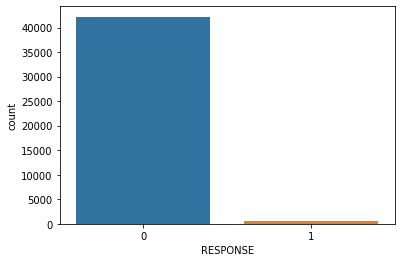

In [259]:
ax = sns.countplot(x='RESPONSE', data=kaggle_results)
display(mailout_train['RESPONSE'].value_counts())